# <center> **Dense Optical Flow** </center>

Dense optical flow attempts to compute the optical flow vector for every pixel of each frame. While such computation may be slower, it gives a more accurate result and a denser result suitable for applications such as learning structure from motion and video segmentation.

In [168]:
# Libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy.ndimage import convolve

## **Image Gradient**

* Image is a matrix of pixel values representing various intensity level values.
* A pixel is the building block of an image.
* The gradient can be defined as the change in the direction of the intensity level of an image.

In [169]:
def image_gradient(img1, img2):
    #derivative masks
    x_kernel = np.array([[-1, 1], [-1, 1]]) * 0.25
    y_kernel = np.array([[-1, -1], [1, 1]]) * 0.25
    t_kernel = np.ones((2, 2)) * 0.25

    fx = convolve(img1,x_kernel)
    fy = convolve(img1, y_kernel)
    ft = convolve(img1, -t_kernel) + convolve(img2, t_kernel)

    return [fx, fy, ft]

# **Horn-Schunck method**

### **Horn-Schunck Function**

In [170]:
# Function: Horn-Schunck Optical Flow method
# PI: Previous image (np.ndarray)
# LI: Last image (np.ndarray)
# corner_list: List corners
# window_size: Window size (tuple)
# Return: vx, vy, corner_list
def Horn_Schunck_Optical_Flow(PI, LI, alpha=1, delta=0.01, num_iter=100, avg_kernel=np.zeros((3, 3))):
    shape = np.shape(PI)

    #removing noise
    beforeImg = PI.astype(float)
    afterImg = LI.astype(float)

    # set up initial values
    u = np.zeros(shape)
    v = np.zeros(shape)

    fx = np.diff(np.pad(afterImg, ((0, 0), (0, 1)), 'edge'), axis=1).reshape(shape) / 2.0
    fy = np.diff(np.pad(afterImg, ((0, 1), (0, 0)), 'edge'), axis=0).reshape(shape) / 2.0
    ft = afterImg - beforeImg

    iter_counter = 0

    while True:
        iter_counter += 1
        u_avg = convolve(u, avg_kernel)
        v_avg = convolve(v, avg_kernel)
        p = fx * u_avg + fy * v_avg + ft
        d = 4 * alpha**2 + fx**2 + fy**2
        prev = u

        u = u_avg - fx * (p / d)
        v = v_avg - fy * (p / d)

        diff = np.linalg.norm(u - prev, 2)

        # Converges check
        if  diff <= delta or iter_counter > num_iter:
            break
    
    return [u, v]

## **Plot image - Plot video**

In [171]:
# Function: Plot Optical Flow
# PI: Previous image (np.ndarray)
# LI: Last image (np.ndarray)
# vx: vx (np.ndarray)
# vy: vy (np.ndarray)
# fig_size: Figure size (tuple)
# threshold: Threshold
# Result: Plot vector on the previous image
def plot_image_optical_flow(img, vx, vy, stride=10):
    height, width = img.shape[:2]
    x, y = np.meshgrid(np.arange(0, width, stride), np.arange(0, height, stride))
    x = x.flatten()
    y = y.flatten()
    flow_vx = vx[::stride, ::stride].flatten()
    flow_vy = vy[::stride, ::stride].flatten()
    plt.imshow(img, cmap='gray')
    plt.quiver(x, y, flow_vx, flow_vy, color='y', angles='xy')
    plt.show()

In [172]:
# Function: Plot Optical Flow
# PI: Previous image (np.ndarray)
# LI: Last image (np.ndarray)
# vx: vx (np.ndarray)
# vy: vy (np.ndarray)
# fig_size: Figure size (tuple)
# threshold: Threshold
# Result: Plot vector on the previous image
def plot_video_optical_flow(frame, mask, vx, vy, threshold=0.3, title="image", color=(0, 255, 0)):
    shape = np.shape(frame)

    for y in range(0, shape[0] - 1):
        for x in range(0, shape[1] - 1):
            if abs(vx[y][x]) > threshold or abs(vy[y][x]) > threshold: # setting the threshold to plot the vectors
                # cv2.circle(frame, (x, y), 5, color[i].tolist(), -1)
                mask = cv2.line(mask, (x, y), (int(x + vx[y][x]), int(y + vy[y][x])), 
                                color = color, thickness = 3)
        
    img = cv2.add(frame, mask)
    cv2.imshow(title, img)
    return mask

### **Test Horn-Schunck function with two frames**

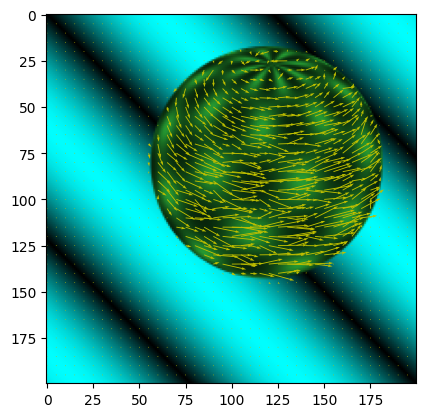

In [174]:
threshold = 0.3
fig_size = (10, 10)
avg_kernel = np.array([[1 / 12, 1 / 6, 1 / 12],
                       [1 / 6 , 0    , 1 / 6 ],
                       [1 / 12, 1 / 6, 1 / 12]], float)

image1 = cv2.imread(r"image/sphere1.bmp")
gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

image2 = cv2.imread(r"image/sphere2.bmp")
gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

vx, vy = Horn_Schunck_Optical_Flow(PI          = gray_image1, 
                                   LI          = gray_image2,
                                   alpha       = 1          , 
                                   delta       = 0.1        ,
                                   num_iter    = 50         ,
                                   avg_kernel  = avg_kernel  )

plot_image_optical_flow(img    = image2, 
                        vx     = vx    , 
                        vy     = vy    , 
                        stride = 5      )

### **Test Horn-Schunck function with video**

# **Compare to OpenCV**